<a href="https://colab.research.google.com/github/farhanarrafi/proto-language-reconstruction-using-bengali-dialects/blob/main/colab/Proto_language_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system =

In [2]:
import os.path
import json
import pandas as pd
#from datasets import Dataset
#from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, accuracy_score, matthews_corrcoef, f1_score
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.pandas()


api_token = {"username":"farhanarrafi","key":"4f070f664abbd64c4eed43162a528d02"}


# https://stackoverflow.com/a/57401752/3148856
if not os.path.isdir('/root/.kaggle'):
  ! mkdir ~/.kaggle
  ! touch ~/.kaggle/kaggle.json
  with open('/root/.kaggle/kaggle.json', 'w') as file:
      json.dump(api_token, file)
  !chmod 600 ~/.kaggle/kaggle.json

#! kaggle datasets list

### Download Dataset

In [ ]:
if not os.path.isfile('BanglaDial.csv'):
    ! kaggle datasets download -d farhanarrafi/bangladial-a-dataset-for-bengali-dialect-analysis
    ! unzip bangladial-a-dataset-for-bengali-dialect-analysis.zip
    ! rm -rf bangladial-a-dataset-for-bengali-dialect-analysis.zip

Dataset URL: https://www.kaggle.com/datasets/farhanarrafi/bangladial-a-dataset-for-bengali-dialect-analysis
License(s): CC-BY-SA-4.0
Archive:  bangladial-a-dataset-for-bengali-dialect-analysis.zip
  inflating: BanglaDial.csv          
  inflating: BanglaDial.xlsx         
  inflating: BanglaDial_ A Merged and Imbalanced text Dataset for Bengali Regional dialect analysis. - Sheet1.csv  
  inflating: BanglaDial_ A Merged and Imbalanced text Dataset for Bengali Regional dialect analysis..xlsx  


In [ ]:



bangladial_dataset = pd.read_csv('BanglaDial.csv')

In [ ]:
bangladial_dataset.head()

,Sentence,Language
0,কেমন আছো ?,Standard_Bangla
1,আজকে আমার মন ভালো নেই,Standard_Bangla
2,তুমি কি করো ?,Standard_Bangla
3,এই গরমে আমার কিছু ভালো লাগে না,Standard_Bangla
4,ছেলেটি সাদা রঙয়ের একটি শার্ট পরে এসেছিল,Standard_Bangla


In [ ]:
bangladial_languages = bangladial_dataset['Language'].unique()

In [ ]:
bangladial_dataset.shape

(63303, 2)

In [ ]:
# bangladial_dataset['row'] = bangladial_dataset.groupby('Language').cumcount()

# # Pivot the table
# bangladial = bangladial_dataset.pivot(index='row', columns='Language', values='Sentence')

# # Optional: reset index if you want a clean DataFrame
# bangladial = bangladial.reset_index(drop=True)


In [ ]:
bangladial = bangladial_dataset
bangladial.head(10)

,Sentence,Language
0,কেমন আছো ?,Standard_Bangla
1,আজকে আমার মন ভালো নেই,Standard_Bangla
2,তুমি কি করো ?,Standard_Bangla
3,এই গরমে আমার কিছু ভালো লাগে না,Standard_Bangla
4,ছেলেটি সাদা রঙয়ের একটি শার্ট পরে এসেছিল,Standard_Bangla
5,মেয়েটি লাল রঙয়ের শাড়ি পরে আমার সাথে দেখা করতে ...,Standard_Bangla
6,ছেলেটি সিলেট থেকে ঢাকায় এসেছে,Standard_Bangla
7,মেয়েটি সিলেট থেকে আসা এই ছেলেটিকে অনেক ভালবাসে,Standard_Bangla
8,ছেলেটি মেয়েটাকে এখনো ভালবাসার চোখে দেখেনি,Standard_Bangla
9,মেয়েটি তাঁর সব স্বপ্নের মধ্যে ছেলেটাকে কল্পনা করে,Standard_Bangla


In [ ]:
if not os.path.isfile('Vashantor/Final/Classification.csv'):
    ! kaggle datasets download -d raiyanzannat/vashantor
    ! unzip vashantor.zip
    ! rm -rf vashantor.zip

Dataset URL: https://www.kaggle.com/datasets/raiyanzannat/vashantor
License(s): apache-2.0
Archive:  vashantor.zip
  inflating: Vashantor/Combined/Barishal_Combined_Translation.csv  
  inflating: Vashantor/Combined/Chittagong_Combined_Translation.csv  
  inflating: Vashantor/Combined/Mymensingh_Combined_Translation.csv  
  inflating: Vashantor/Combined/Noakhali_Combined_Translation.csv  
  inflating: Vashantor/Combined/Sylhet_Combined_Translation.csv  
  inflating: Vashantor/Final/Barishal.csv  
  inflating: Vashantor/Final/Chittagong.csv  
  inflating: Vashantor/Final/Classification.csv  
  inflating: Vashantor/Final/Mymensingh.csv  
  inflating: Vashantor/Final/Noakhali.csv  
  inflating: Vashantor/Final/Sylhet.csv  


In [ ]:
vashantor_barishal = pd.read_csv('Vashantor/Final/Barishal.csv')
vashantor_chittagong = pd.read_csv('Vashantor/Final/Chittagong.csv')
vashantor_noakhali = pd.read_csv('Vashantor/Final/Noakhali.csv')
vashantor_mymensingh = pd.read_csv('Vashantor/Final/Mymensingh.csv')
vashantor_sylhet = pd.read_csv('Vashantor/Final/Sylhet.csv')

In [ ]:
vashantor_barishal.columns = vashantor_barishal.columns.str.strip()
vashantor_chittagong.columns = vashantor_chittagong.columns.str.strip()
vashantor_noakhali.columns = vashantor_noakhali.columns.str.strip()
vashantor_mymensingh.columns = vashantor_mymensingh.columns.str.strip()
vashantor_sylhet.columns = vashantor_sylhet.columns.str.strip()

In [ ]:
vashantor_barishal = vashantor_barishal.dropna()
vashantor_chittagong = vashantor_chittagong.dropna()
vashantor_noakhali = vashantor_noakhali.dropna()
vashantor_mymensingh = vashantor_mymensingh.dropna()
vashantor_sylhet = vashantor_sylhet.dropna()

In [ ]:
"""
  The format of the input text MUST BE: <district> <bengali_text>
"""
vashantor_barishal['combined'] = vashantor_barishal['region_name'] + ' ' + vashantor_barishal['regional_text']
vashantor_chittagong['combined'] = vashantor_chittagong['region_name'] + ' ' + vashantor_chittagong['regional_text']
vashantor_noakhali['combined'] = vashantor_noakhali['region_name'] + ' ' + vashantor_noakhali['regional_text']
vashantor_mymensingh['combined'] = vashantor_mymensingh['region_name'] + ' ' + vashantor_mymensingh['regional_text']
vashantor_sylhet['combined'] = vashantor_sylhet['region_name'] + ' ' + vashantor_sylhet['regional_text']

In [ ]:
vashantor_chittagong.head()

,regional_text,bangla_speech,region_name,combined
0,বাংলাদেশত ৬৪ ইয়ান জেলা,বাংলাদেশে ৬৪ টা জেলা,Chittagong,Chittagong বাংলাদেশত ৬৪ ইয়ান জেলা
1,আরা বেয়াক্কুন গতহালিয়া বাইরে গেইলাম,আমরা সবাই গতকাল বাহিরে গিয়েছিলাম,Chittagong,Chittagong আরা বেয়াক্কুন গতহালিয়া বাইরে গেইলাম
2,তোইয়ার হতা বলার ধরণ বহুত সুন্দর,তোমার কথা বলার ধরন অনেক সুন্দর,Chittagong,Chittagong তোইয়ার হতা বলার ধরণ বহুত সুন্দর
3,বরিশালর মানুষ হইল্লে অয় দে?,বরিশালের মানুষ কেমন হয়?,Chittagong,Chittagong বরিশালর মানুষ হইল্লে অয় দে?
4,খুলনা জেলা কি বহুত সুন্দর নাকি?,খুলনা জেলা কি অনেক সুন্দর?,Chittagong,Chittagong খুলনা জেলা কি বহুত সুন্দর নাকি?


In [ ]:
vashantor_barishal['combined'].str.len().max()

123

In [ ]:
# https://huggingface.co/teamapocalypseml/regben2ipa-byt5small
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("abdullaharean/regipa_bangla")
model = AutoModelForSeq2SeqLM.from_pretrained("abdullaharean/regipa_bangla")

In [ ]:
#text = "<district> bengali_text_here"
text = vashantor_barishal['combined'][2]
inputs = tokenizer(text, return_tensors='pt')
output_ids = model.generate(**inputs,
        max_length=128,   # or 256, depending on your text length
        num_beams=4,      # optional: makes output better (beam search)
        early_stopping=True)
print(tokenizer.decode(output_ids[0], skip_special_tokens=False))

<pad>bɐɾɔhɐl  t̪umɪ kɪ moɾe e͡ɪ̯ kɐmdɐ ko͡ɪ̯ɾɾɐ d̪et̪e pɐɾbɐ?</s>


In [ ]:
outputs = []

"""
  The format of the input text MUST BE: <district> <bengali_text>
"""
model = model.to(device)

def translate_text(text):
    inputs = tokenizer(text, return_tensors='pt').to(device)
    output_ids = model.generate(**inputs,
        max_length=128,   # or 256, depending on your text length
        num_beams=4,      # optional: makes output better (beam search)
        early_stopping=True)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)



In [ ]:
vashantor_barishal['ipa_output'] = vashantor_barishal['combined'].astype(str).apply(translate_text)

In [ ]:
vashantor_barishal.to_csv('vashantor_barishal_ipa.csv', index=False)

In [ ]:
vashantor_chittagong['ipa_output'] = vashantor_chittagong['combined'].astype(str).progress_apply(translate_text)

100%|██████████| 2499/2499 [30:11<00:00,  1.38it/s]


In [ ]:
vashantor_chittagong.to_csv('vashantor_chittagong_ipa.csv', index=False)

In [ ]:
vashantor_noakhali['ipa_output'] = vashantor_noakhali['combined'].astype(str).progress_apply(translate_text)
vashantor_noakhali.to_csv('vashantor_noakhali_ipa.csv', index=False)

100%|██████████| 2499/2499 [30:26<00:00,  1.37it/s]


In [ ]:
vashantor_mymensingh['ipa_output'] = vashantor_mymensingh['combined'].astype(str).progress_apply(translate_text)
vashantor_mymensingh.to_csv('vashantor_mymensingh_ipa.csv', index=False)

100%|██████████| 2499/2499 [30:41<00:00,  1.36it/s]


In [ ]:
vashantor_sylhet['ipa_output'] = vashantor_sylhet['combined'].astype(str).progress_apply(translate_text)
vashantor_sylhet.to_csv('vashantor_sylhet_ipa.csv', index=False)

100%|██████████| 2499/2499 [30:30<00:00,  1.36it/s]


In [ ]:
vashantor_barishal = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_chittagong = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_noakhali = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_mymensingh = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')
vashantor_sylhet = pd.read_csv('vashantor_noakhali_ipa_with_bangla_ipa.csv')

In [ ]:
#import epitran

# # Apply the transliteration function to the 'text' column
# df['bangla_speech_ipa'] = df['bangla_speech'].progress_apply(lambda x: epi_beng.transliterate(str(x)))

# df.to_csv('vashantor_sylhet_ipa_with_bangla_ipa.csv', index=False)

# PIE Root prediction

### T5 Small

In [4]:
bangla_w_pie_root = pd.read_csv('bangla_with_pie_roots_reflex_index.csv')
bangla_without_pie_root = pd.read_csv('bangla_with_no_pie_root_matches_reflex_index.csv')

In [5]:
# Construct input strings from dialectal IPA
def generate_input(row):
    return (
        f"[standard] {row['bangla_speech_ipa']} "
        f"[barishal] {row['barishal_ipa']} "
        f"[sylhet] {row['sylhet_ipa']} "
        f"[mymensingh] {row['mymensingh_ipa']} "
        f"[noakhali] {row['noakhali_ipa']} "
        f"[chittagong] {row['chittagong_ipa']}"
    )

bangla_w_pie_root["input_text"] = bangla_w_pie_root.apply(generate_input, axis=1)
bangla_w_pie_root["target_text"] = bangla_w_pie_root["PIE_root"]

In [6]:
bangla_w_pie_root.head()

,bangla_speech_word,bangla_speech_ipa,barishal_word,barishal_ipa,sylhet_word,sylhet_ipa,mymensingh_word,mymensingh_ipa,noakhali_word,noakhali_ipa,chittagong_word,chittagong_ipa,english_translation,PIE_root,PIE_gloss,input_text,target_text
0,অংশ,oŋɕɔ,অংশ,ɔŋʃo,অংশ,ɔŋʃo,অংশ,ɔŋʃo,অংশ,ɔŋʃo,অংশ,ɔŋʃo,Part,2c. per-,part,[standard] oŋɕɔ [barishal] ɔŋʃo [sylhet] ɔŋʃo ...,2c. per-
1,অঘটন,o̤ɡ̤ɔtɔn̪ɔ,অঘটন,ɔgʱɔton,অঘটন,ɔgʱɔton,অঘটন,ɔgʱɔton,অঘটন,ɔgʱɔton,দূর,d̪uɾ,Incident,1. k̑ad-,incident,[standard] o̤ɡ̤ɔtɔn̪ɔ [barishal] ɔgʱɔton [sylh...,1. k̑ad-
2,অচেনা,ot͡ɕen̪a,অচেনা,ɔcenɐ,অচেনা,ɔcenɐ,অচেনা,ɔcenɐ,যেতাগোরে,ɟet̪ɐgoɾe,অচেনা,ɔcenɐ,Strange,eg̑hs,strange,[standard] ot͡ɕen̪a [barishal] ɔcenɐ [sylhet] ...,eg̑hs
3,অঞ্চল,ont͡ɕɔl̪ɔ,অঞ্চল,ɔncɔl,দু্র্যোগ,d̪uɾɟog,অঞ্চল,ɔncɔl,প্রভন,pɾobʱon,আঞ্চল,ɐncɔl,Region,1. reg̑-,region,[standard] ont͡ɕɔl̪ɔ [barishal] ɔncɔl [sylhet]...,1. reg̑-
4,অঞ্চলের,ont͡ɕɔl̪erɔ,এলাকার,elɐkɐɾ,জেগার,ɟegɐɾ,অঞ্চলের,ɔncoleɾ,অঞ্চলের,ɔncoleɾ,অঞ্চল,ɔncɔl,Region,1. reg̑-,region,[standard] ont͡ɕɔl̪erɔ [barishal] elɐkɐɾ [sylh...,1. reg̑-


In [8]:
from datasets import Dataset
# Convert to Hugging Face dataset
dataset = Dataset.from_pandas(bangla_w_pie_root[["input_text", "target_text"]])

In [102]:
from transformers import Trainer, TrainingArguments, T5ForConditionalGeneration, T5Tokenizer

# Tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/mt5-small")
model = T5ForConditionalGeneration.from_pretrained("google/mt5-small").to(device)

You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [103]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters     : {total_params}")
print(f"Trainable parameters : {trainable_params}")

Total parameters     : 300176768
Trainable parameters : 300176768


In [11]:
# Tokenization functions
def tokenize(batch):
    inputs = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length=128)
    targets = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length=32)
    inputs["labels"] = targets["input_ids"]
    return inputs

dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/2403 [00:00<?, ? examples/s]

In [12]:
# Split into train/test (90/10)
split = dataset.train_test_split(test_size=0.1, seed=11)
train_dataset = split["train"]
eval_dataset = split["test"]

In [14]:
# TrainingArguments
training_args = TrainingArguments(
    output_dir="t5-pie",
    logging_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=20,
    save_total_limit=2,
    logging_dir="logs",
    report_to="none",  # turn off W&B
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)

In [15]:
train_result = trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
541,21.551100
1082,4.302100
1623,1.941500
2164,0.965100
2705,0.669700
3246,0.549000
3787,0.489300
4328,0.451100
4869,0.424800
5410,0.405600


In [27]:
def predict_proto(word_row):
    input_str = generate_input(word_row)
    inputs = tokenizer(input_str, return_tensors="pt", truncation=True, padding=True).to(device)
    output_ids = model.generate(**inputs, max_length=32).to(device)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

sample = bangla_w_pie_root.iloc[0]
print("Predicted PIE root:", predict_proto(sample))
print("Gold PIE root:", sample["PIE_root"])

Predicted PIE root: 1. g̑en-
Gold PIE root: 2c. per-


In [44]:
for i in range(0,5):
    sample = bangla_w_pie_root.iloc[i]
    input = sample['bangla_speech_ipa'] + " " + sample['barishal_ipa'] + " " + sample['sylhet_ipa'] + " " + sample['mymensingh_ipa'] + " " + sample['noakhali_ipa'] + " " + sample['chittagong_ipa']

    print("Input:", input)
    print("Output:", predict_proto(sample))
    print("Expected:", sample["PIE_root"])


Input: oŋɕɔ ɔŋʃo ɔŋʃo ɔŋʃo ɔŋʃo ɔŋʃo
Output: 1. g̑hē-
Expected: 2c. per-
Input: o̤ɡ̤ɔtɔn̪ɔ ɔgʱɔton ɔgʱɔton ɔgʱɔton ɔgʱɔton d̪uɾ
Output: 1. g̑-
Expected: 1. k̑ad-
Input: ot͡ɕen̪a ɔcenɐ ɔcenɐ ɔcenɐ ɟet̪ɐgoɾe ɔcenɐ
Output: g̑herdh-
Expected: eg̑hs
Input: ont͡ɕɔl̪ɔ ɔncɔl d̪uɾɟog ɔncɔl pɾobʱon ɐncɔl
Output: manu-
Expected: 1. reg̑-
Input: ont͡ɕɔl̪erɔ elɐkɐɾ ɟegɐɾ ɔncoleɾ ɔncoleɾ ɔncɔl
Output: 1. u̯ē-
Expected: 1. reg̑-


In [32]:
logs = trainer.state.log_history
train_loss = [log["loss"] for log in logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in logs if "eval_loss" in log]

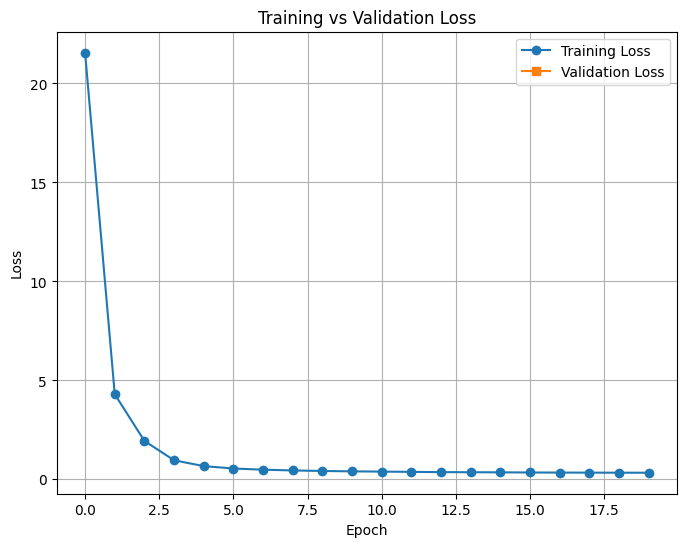

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label="Training Loss", marker='o')
plt.plot(eval_loss, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
def get_predictions(dataset):
    predictions = []
    references = []
    for row in dataset:
        input_str = row["input_text"]
        inputs = tokenizer(input_str, return_tensors="pt", truncation=True).to(device)
        output_ids = model.generate(**inputs, max_length=32).to(device)
        prediction = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        predictions.append(prediction)
        references.append(row["target_text"])
    return predictions, references

preds, refs = get_predictions(eval_dataset)

In [46]:
# Accuracy
exact_matches = [p == r for p, r in zip(preds, refs)]
acc = np.mean(exact_matches)
print(f"Exact Match Accuracy: {acc:.2f}")

Exact Match Accuracy: 0.00


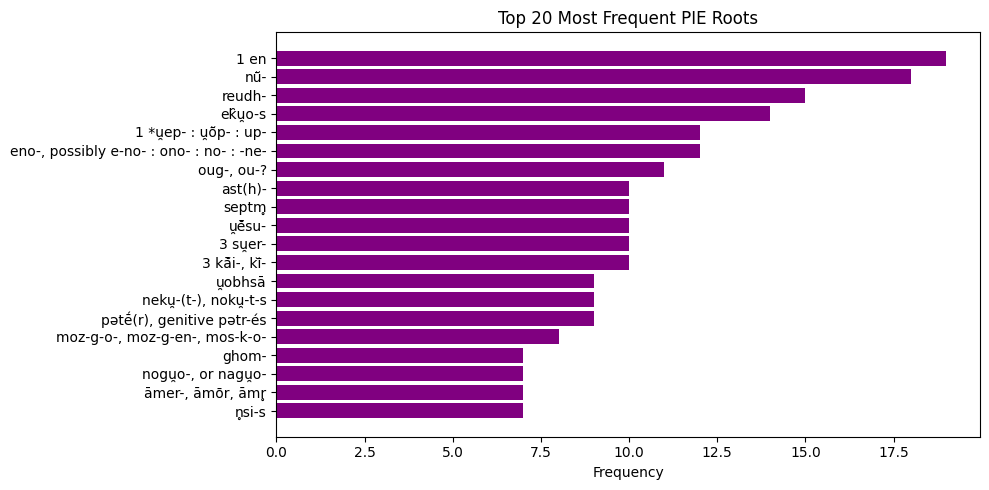

In [ ]:
from collections import Counter

root_counts = Counter(bangla_w_pie_root["PIE_root"])
most_common = root_counts.most_common(20)

labels, values = zip(*most_common)
plt.figure(figsize=(10, 5))
plt.barh(labels, values, color='purple')
plt.gca().invert_yaxis()
plt.title("Top 20 Most Frequent PIE Roots")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

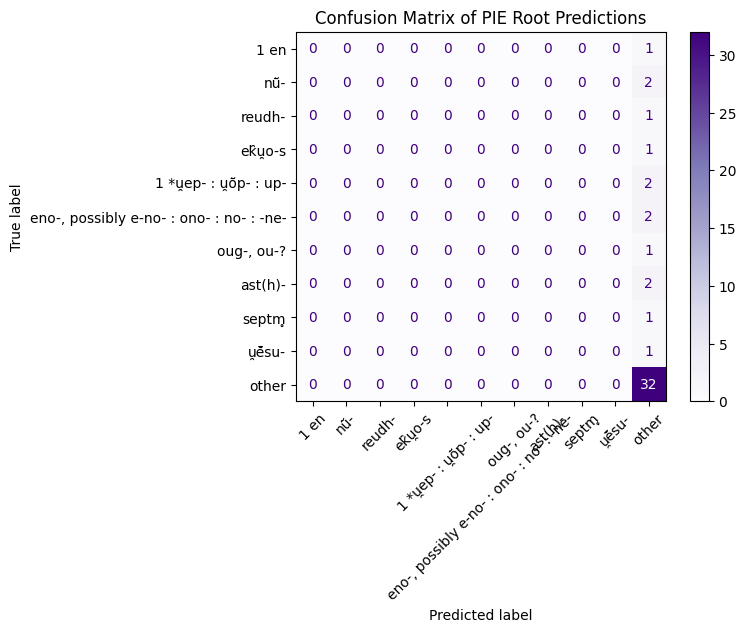

In [ ]:
# Focus only on top N most frequent roots
top_roots = [r for r, c in most_common[:10]]
filtered_preds = [p if p in top_roots else "other" for p in preds]
filtered_refs = [r if r in top_roots else "other" for r in refs]

cm = confusion_matrix(filtered_refs, filtered_preds, labels=top_roots + ["other"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_roots + ["other"])
disp.plot(xticks_rotation=45, cmap="Purples")
plt.title("Confusion Matrix of PIE Root Predictions")
plt.show()

### Seq2SeqModel with LSTM

In [48]:
bangla_w_pie_root = pd.read_csv('bangla_with_pie_roots_reflex_index.csv')
bangla_without_pie_root = pd.read_csv('bangla_with_no_pie_root_matches_reflex_index.csv')

In [49]:
bangla_w_pie_root.head()

,bangla_speech_word,bangla_speech_ipa,barishal_word,barishal_ipa,sylhet_word,sylhet_ipa,mymensingh_word,mymensingh_ipa,noakhali_word,noakhali_ipa,chittagong_word,chittagong_ipa,english_translation,PIE_root,PIE_gloss
0,অংশ,oŋɕɔ,অংশ,ɔŋʃo,অংশ,ɔŋʃo,অংশ,ɔŋʃo,অংশ,ɔŋʃo,অংশ,ɔŋʃo,Part,2c. per-,part
1,অঘটন,o̤ɡ̤ɔtɔn̪ɔ,অঘটন,ɔgʱɔton,অঘটন,ɔgʱɔton,অঘটন,ɔgʱɔton,অঘটন,ɔgʱɔton,দূর,d̪uɾ,Incident,1. k̑ad-,incident
2,অচেনা,ot͡ɕen̪a,অচেনা,ɔcenɐ,অচেনা,ɔcenɐ,অচেনা,ɔcenɐ,যেতাগোরে,ɟet̪ɐgoɾe,অচেনা,ɔcenɐ,Strange,eg̑hs,strange
3,অঞ্চল,ont͡ɕɔl̪ɔ,অঞ্চল,ɔncɔl,দু্র্যোগ,d̪uɾɟog,অঞ্চল,ɔncɔl,প্রভন,pɾobʱon,আঞ্চল,ɐncɔl,Region,1. reg̑-,region
4,অঞ্চলের,ont͡ɕɔl̪erɔ,এলাকার,elɐkɐɾ,জেগার,ɟegɐɾ,অঞ্চলের,ɔncoleɾ,অঞ্চলের,ɔncoleɾ,অঞ্চল,ɔncɔl,Region,1. reg̑-,region


In [50]:
bangla_w_pie_root.shape

(2403, 15)

In [51]:

inputs = []
targets = []

for _, row in bangla_w_pie_root.iterrows():
    ipa_array = [
        row['bangla_speech_ipa'],
        row['barishal_ipa'],
        row['sylhet_ipa'],
        row['mymensingh_ipa'],
        row['noakhali_ipa'],
        row['chittagong_ipa']
    ]
    inputs.append(ipa_array)
    targets.append(row['PIE_root'])

# Flatten the list of input arrays into a single list of strings
flattened_inputs = [''.join(ipa_array) for ipa_array in inputs]
#flattened_targets = [''.join(ipa_array_target) for ipa_array_target in targets]

# Combine all text from inputs and targets
all_text = ' '.join(flattened_inputs) + ''.join(targets)

# char_to_idx = {char: idx for idx, char in enumerate(sorted(vocab))}
# idx_to_char = {idx: char for char, idx in char_to_idx.items()}

# Build character-level vocabulary
vocab = set(all_text)
vocab.add(' ')
vocab_size = len(vocab)
char_to_idx = {char: idx for idx, char in enumerate(sorted(vocab))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

In [52]:
# Encode the inputs and targets
def encode_sequence(seq):
    return [char_to_idx[char] for char in seq if char in char_to_idx]

input_seqs = [encode_sequence(seq) for seq in inputs]
target_seqs = [encode_sequence(seq) for seq in targets]

# # Padding function to ensure equal length sequences
# def pad_sequence(sequences, max_len):
#     return [seq + [char_to_idx[' ']] * (max_len - len(seq)) for seq in sequences]

max_input_len = max([len(seq) for seq in input_seqs])
max_target_len = max([len(seq) for seq in target_seqs])

# input_seqs_padded = pad_sequence(input_seqs, max_input_len)
# target_seqs_padded = pad_sequence(target_seqs, max_target_len)

def pad_sequence(sequences, max_len, char_to_idx):
    return [seq + [char_to_idx[' ']] * (max_len - len(seq)) for seq in sequences]


# Pad sequences
padded_inputs = pad_sequence(input_seqs, max_input_len, char_to_idx)
padded_targets = pad_sequence(target_seqs, max_target_len, char_to_idx)

In [53]:
train_inputs, test_inputs, train_targets, test_targets = train_test_split(padded_inputs, padded_targets, test_size=0.1)

In [100]:
# Model definition
class Seq2SeqModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(Seq2SeqModel, self).__init__()
        self.embedding = nn.Embedding(input_size, hidden_size)  # Embedding layer
        self.encoder = nn.LSTM(hidden_size, hidden_size, num_layers=2, batch_first=True)
        self.decoder = nn.LSTM(hidden_size, hidden_size, num_layers=2, batch_first=True)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, y=None):
        x = self.embedding(x)  # Apply embedding layer to input sequence

        # Encoder
        _, (h, c) = self.encoder(x)  # Encoder outputs

        # Decoder needs target sequence as input
        if y is not None:
            y = self.embedding(y)  # Apply embedding to the target sequence

        output, _ = self.decoder(y, (h, c))  # Decoder

        logits = self.output_layer(output)  # Output layer to predict the PIE root
        return logits


# Model initialization
hidden_size = 512
model = Seq2SeqModel(vocab_size, vocab_size, hidden_size)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # Ignore padding
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [101]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters     : {total_params}")
print(f"Trainable parameters : {trainable_params}")

Total parameters     : 8503392
Trainable parameters : 8503392


In [55]:
# Prepare DataLoader
class CognateDataset(torch.utils.data.Dataset):
    def __init__(self, input_tensor, target_tensor):
        self.inputs = input_tensor
        self.targets = target_tensor

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        # Make sure to return tensors
        return torch.tensor(self.inputs[idx], dtype=torch.long), torch.tensor(self.targets[idx], dtype=torch.long)

In [56]:
train_dataset = CognateDataset(train_inputs, train_targets)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_dataset = CognateDataset(test_inputs, test_targets)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [57]:
# Training loop
train_losses, val_losses = [], []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_inputs, batch_targets in train_loader:
        optimizer.zero_grad()

        # Forward pass
        output = model(batch_inputs, batch_targets)

        # Calculate loss
        loss = criterion(output.view(-1, vocab_size), batch_targets.view(-1))
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation step
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for batch_inputs, batch_targets in test_loader:
            output = model(batch_inputs, batch_targets)
            loss = criterion(output.view(-1, vocab_size), batch_targets.view(-1))
            val_loss += loss.item()
        val_losses.append(val_loss / len(test_loader))

    print(f'Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}')

Epoch 1: Train Loss = 0.0769, Val Loss = 0.0005
Epoch 2: Train Loss = 0.0009, Val Loss = 0.0003
Epoch 3: Train Loss = 0.0004, Val Loss = 0.0001
Epoch 4: Train Loss = 0.0000, Val Loss = 0.0000
Epoch 5: Train Loss = 0.0000, Val Loss = 0.0000
Epoch 6: Train Loss = 0.0000, Val Loss = 0.0000
Epoch 7: Train Loss = 0.0000, Val Loss = 0.0000
Epoch 8: Train Loss = 0.0000, Val Loss = 0.0000
Epoch 9: Train Loss = 0.0000, Val Loss = 0.0000
Epoch 10: Train Loss = 0.0000, Val Loss = 0.0000


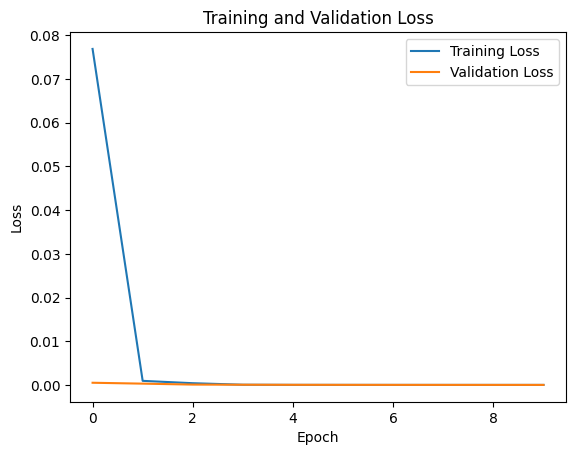

In [58]:
# Plotting the loss curves
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Converts tensor indices to string
def decode_sequence(seq_tensor, idx_to_char):
    return [''.join([idx_to_char[idx.item()] for idx in seq if idx.item() != char_to_idx[' ']]) for seq in seq_tensor]


In [60]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch_inputs, batch_targets in test_loader:
        output = model(batch_inputs, batch_targets)  # shape: (batch_size, seq_len, vocab_size)
        predicted = output.argmax(dim=2)             # shape: (batch_size, seq_len)

        # Decode sequences into strings
        decoded_preds = decode_sequence(predicted, idx_to_char)
        decoded_targets = decode_sequence(batch_targets, idx_to_char)

        # Optional: keep only fully matching sequences (strict match)
        all_preds.extend(decoded_preds)
        all_targets.extend(decoded_targets)

In [61]:
# Flatten all characters
flat_preds = ''.join(all_preds)
flat_targets = ''.join(all_targets)

# Ensure lengths match
min_len = min(len(flat_preds), len(flat_targets))
flat_preds = flat_preds[:min_len]
flat_targets = flat_targets[:min_len]

# Convert characters to indices
char_set = list(set(flat_preds + flat_targets))
char_to_label = {ch: i for i, ch in enumerate(char_set)}

y_true = [char_to_label[c] for c in flat_targets]
y_pred = [char_to_label[c] for c in flat_preds]

# Compute metrics
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
mcc = matthews_corrcoef(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
MCC: 1.0000


Seq2SeqModel ends

### GRU with Attention Model

In [87]:
inputs = []
targets = []

# Step 1: Prepare input and target text
for _, row in bangla_w_pie_root.iterrows():
    ipa_array = [
        row['bangla_speech_ipa'],
        row['barishal_ipa'],
        row['sylhet_ipa'],
        row['mymensingh_ipa'],
        row['noakhali_ipa'],
        row['chittagong_ipa']
    ]
    inputs.append(''.join(ipa_array))  # Flatten IPA forms
    targets.append(f"<s>{row['PIE_root']}</s>")  # Step 2: Add start/end tokens

# Step 1: Build vocabulary (include special tokens and space for padding)
special_tokens = ['<s>', '</s>', ' ']
all_text = ' '.join(inputs) + ' ' + ''.join(targets)
vocab = set(all_text).union(set(special_tokens))
char_to_idx = {char: idx for idx, char in enumerate(sorted(vocab))}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
vocab_size = len(char_to_idx)

# Step 2: Encoding function
def encode_sequence(seq):
    return [char_to_idx[char] for char in seq if char in char_to_idx]

input_seqs = [encode_sequence(seq) for seq in inputs]
target_seqs = [encode_sequence(seq) for seq in targets]

# Step 3: Padding function
def pad_sequence(sequences, max_len, pad_idx):
    return [seq + [pad_idx] * (max_len - len(seq)) for seq in sequences]

pad_idx = char_to_idx[' ']
max_input_len = max(len(seq) for seq in input_seqs)
max_target_len = max(len(seq) for seq in target_seqs)

padded_inputs = pad_sequence(input_seqs, max_input_len, pad_idx)
padded_targets = pad_sequence(target_seqs, max_target_len, pad_idx)


In [88]:
batch_size = 8

# Split into train and validation sets (80/20 split)
train_inputs, val_inputs, train_targets, val_targets = train_test_split(padded_inputs, padded_targets, test_size=0.2, random_state=42)

train_input_tensor = torch.tensor(train_inputs, dtype=torch.long)
train_target_tensor = torch.tensor(train_targets, dtype=torch.long)
val_input_tensor = torch.tensor(val_inputs, dtype=torch.long)
val_target_tensor = torch.tensor(val_targets, dtype=torch.long)

train_dataset = TensorDataset(train_input_tensor, train_target_tensor)
val_dataset = TensorDataset(val_input_tensor, val_target_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [89]:
def compute_metrics(y_true, y_pred):
    skip_ids = {char_to_idx[' '], char_to_idx['<s>'], char_to_idx['</s>']}
    y_true_flat = []
    y_pred_flat = []

    for true_seq, pred_seq in zip(y_true, y_pred):
        for t, p in zip(true_seq, pred_seq):
            if t not in skip_ids:
                y_true_flat.append(t)
                y_pred_flat.append(p)

    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, average='macro', zero_division=0)
    mcc = matthews_corrcoef(y_true_flat, y_pred_flat)
    return accuracy, precision, recall, f1, mcc

In [90]:
def decode_prediction(pred_seq, idx_to_char):
    chars = [idx_to_char[idx] for idx in pred_seq if idx in idx_to_char]
    # Remove tokens
    if '<s>' in chars: chars.remove('<s>')
    if '</s>' in chars: chars.remove('</s>')
    return ''.join(chars).strip()


In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assumed preprocessed variables
# input_seqs_padded: list of input sequence indices
# target_seqs_padded: list of target sequence indices
# char_to_idx, idx_to_char: vocab mappings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class GRUAttentionModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.encoder = nn.GRU(hidden_size, hidden_size, num_layers=4, dropout=dropout,  batch_first=True)
        self.decoder = nn.GRU(hidden_size + hidden_size, hidden_size, num_layers=4, dropout=dropout,  batch_first=True)
        self.output = nn.Linear(hidden_size, vocab_size)

    def forward(self, src, tgt):

        batch_size, tgt_len = tgt.size()

        embedded_src = self.dropout(self.embedding(src))
        embedded_tgt = self.dropout(self.embedding(tgt))

        encoder_outputs, hidden = self.encoder(embedded_src)

        outputs = torch.zeros(batch_size, tgt_len, self.hidden_size).to(src.device)
        decoder_hidden = hidden

        for t in range(tgt_len):
            decoder_input = embedded_tgt[:, t].unsqueeze(1)  # (batch, 1, hidden)
            decoder_hidden_t = decoder_hidden[-1].unsqueeze(1)  # (batch, 1, hidden)

            attn_weights = torch.bmm(decoder_hidden_t, encoder_outputs.transpose(1, 2))  # (batch, 1, src_len)
            attn_weights = torch.nn.functional.softmax(attn_weights, dim=2)
            context = torch.bmm(attn_weights, encoder_outputs)  # (batch, 1, hidden)

            rnn_input = torch.cat((decoder_input, context), dim=2)  # (batch, 1, hidden*2)
            output, decoder_hidden = self.decoder(rnn_input, decoder_hidden)
            outputs[:, t] = output.squeeze(1)

        logits = self.output(outputs)
        return logits

hidden_size = 64
vocab_size = len(char_to_idx)
model = GRUAttentionModel(vocab_size, hidden_size).to(device)
pad_idx = char_to_idx[' ']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [119]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters     : {total_params}")
print(f"Trainable parameters : {trainable_params}")

Total parameters     : 224352
Trainable parameters : 224352


In [110]:
num_epochs = 20
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_inputs, batch_targets in train_loader:
        batch_inputs = batch_inputs.to(device)
        batch_targets = batch_targets.to(device)

        optimizer.zero_grad()
        output = model(batch_inputs, batch_targets)

        # Exclude <s> token from loss (i.e., ignore_index should be for ' ' and '<s>')
        loss = criterion(output.view(-1, vocab_size), batch_targets.view(-1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for val_inputs_batch, val_targets_batch in val_loader:
            val_inputs_batch = val_inputs_batch.to(device)
            val_targets_batch = val_targets_batch.to(device)

            val_outputs = model(val_inputs_batch, val_targets_batch)

            # Exclude <s> token from loss during validation
            loss = criterion(val_outputs.view(-1, vocab_size), val_targets_batch.view(-1))
            val_loss += loss.item()

            preds = val_outputs.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(val_targets_batch.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Compute metrics, excluding <s> token
    acc, prec, rec, f1, mcc = compute_metrics(all_targets, all_preds)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    print(f"Metrics — Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, MCC: {mcc:.4f}")


Epoch 1/20 | Train Loss: 1.2963 | Validation Loss: 0.6281
Metrics — Acc: 0.8128, Prec: 0.2750, Rec: 0.3175, F1: 0.2785, MCC: 0.7958
Epoch 2/20 | Train Loss: 0.4500 | Validation Loss: 0.2228
Metrics — Acc: 0.9294, Prec: 0.5355, Rec: 0.5444, F1: 0.5240, MCC: 0.9229
Epoch 3/20 | Train Loss: 0.1526 | Validation Loss: 0.0499
Metrics — Acc: 0.9912, Prec: 0.7685, Rec: 0.7807, F1: 0.7729, MCC: 0.9903
Epoch 4/20 | Train Loss: 0.0537 | Validation Loss: 0.0182
Metrics — Acc: 0.9971, Prec: 0.8392, Rec: 0.8463, F1: 0.8413, MCC: 0.9968
Epoch 5/20 | Train Loss: 0.0261 | Validation Loss: 0.0085
Metrics — Acc: 0.9992, Prec: 0.9513, Rec: 0.9507, F1: 0.9501, MCC: 0.9992
Epoch 6/20 | Train Loss: 0.0145 | Validation Loss: 0.0044
Metrics — Acc: 0.9995, Prec: 0.9508, Rec: 0.9575, F1: 0.9536, MCC: 0.9995
Epoch 7/20 | Train Loss: 0.0092 | Validation Loss: 0.0023
Metrics — Acc: 0.9998, Prec: 0.9949, Rec: 0.9983, F1: 0.9962, MCC: 0.9998
Epoch 8/20 | Train Loss: 0.0073 | Validation Loss: 0.0020
Metrics — Acc: 0.9

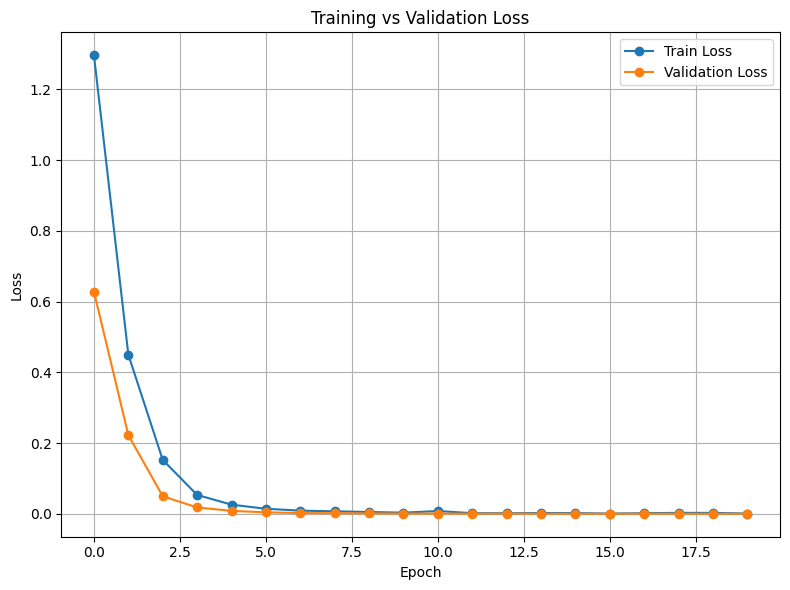

In [111]:
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
for i in range(0,5):
    sample = bangla_w_pie_root.iloc[i]
    input = sample['bangla_speech_ipa'] + " " + sample['barishal_ipa'] + " " + sample['sylhet_ipa'] + " " + sample['mymensingh_ipa'] + " " + sample['noakhali_ipa'] + " " + sample['chittagong_ipa']
    test_sequences.append(input)


In [113]:
def predict(model, input_seq, char_to_idx, idx_to_char, max_target_len=30):
    model.eval()
    with torch.no_grad():
        input_seq = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)  # (1, seq_len)
        embedded_input = model.embedding(input_seq)
        encoder_outputs, hidden = model.encoder(embedded_input)

        # Start with <s>
        start_token_idx = char_to_idx['<s>']
        end_token_idx = char_to_idx['</s>']
        decoder_input = torch.tensor([[start_token_idx]], dtype=torch.long).to(device)
        embedded_input = model.embedding(decoder_input)

        decoder_hidden = hidden
        generated_indices = []

        for _ in range(max_target_len):
            # Attention: context vector from encoder
            decoder_hidden_t = decoder_hidden[-1].unsqueeze(1)
            attn_weights = torch.bmm(decoder_hidden_t, encoder_outputs.transpose(1, 2))
            attn_weights = torch.nn.functional.softmax(attn_weights, dim=2)
            context = torch.bmm(attn_weights, encoder_outputs)

            # Decoder input is (decoder_input + context)
            rnn_input = torch.cat((embedded_input, context), dim=2)
            output, decoder_hidden = model.decoder(rnn_input, decoder_hidden)

            logits = model.output(output.squeeze(1))  # (1, vocab_size)
            next_token = logits.argmax(dim=1).item()
            if next_token == end_token_idx:
                break

            generated_indices.append(next_token)

            # Prepare next input
            embedded_input = model.embedding(torch.tensor([[next_token]], dtype=torch.long).to(device))

        # Decode generated indices to characters
        predicted_sequence = ''.join([idx_to_char[idx] for idx in generated_indices])
        return predicted_sequence


In [117]:
for i in range(1000,1020):
    input_seq = padded_inputs[i]
    pred = predict(model, input_seq, char_to_idx, idx_to_char)
    input_text = ''.join([idx_to_char[idx] for idx in input_seq if idx != char_to_idx[' ']])
    target_text = ''.join([idx_to_char[idx] for idx in padded_targets[i] if idx not in {char_to_idx[' '], char_to_idx['<s>'], char_to_idx['</s>']}])

    print(f"\nInput:  {input_text}")
    print(f"Target: {target_text}")
    print(f"Pred:   {pred}")


Input:  bɔl̪et͡ɕʰil̪ko͡ɪ̯cʰeleko͡ɪ̯cʰɔlɐko͡ɪ̯ʃɪnko͡ɪ̯cʰɪloho͡ɪ̯l
Target: <s>2.seku̯-</s>
Pred:   ōōōōōōōōōōōōōōōōōōōōōōōōōōōōōō

Input:  bɔl̪et͡ɕʰil̪ɔko͡ɪ̯ʃeleko͡ɪ̯cʰɔlɐko͡ɪ̯sɪlko͡ɪ̯sɪloho͡ɪ̯l
Target: <s>2.seku̯-</s>
Pred:   ōōōōōōōōōōōōōōōōōōōōōōōōōōōōōō

Input:  bɔl̪et͡ɕʰil̪amɔko͡ɪ̯cʰɪlɐmko͡ɪ̯lɐmko͡ɪ̯sɪlɐmbɪʲɐgɐho͡ɪ̯ʲɪ
Target: <s>2.seku̯-</s>
Pred:   ōōōōōōōōōōōōōōōōōōōōōōōōōōōōōō

Input:  bɔl̪et͡ɕʰeko͡ɪ̯cʰebolecʰeko͡ɪ̯ʃeko͡ɪ̯ʃeho͡ɪ̯ʲe
Target: <s>2.seku̯-</s>
Pred:   ōōōōōōōōōōōōōōōōōōōōōōōōōōōōōō

Input:  bɔl̪et͡ɕʰen̪ko͡ɪ̯cʰenmɐt̪lɐko͡ɪ̯ʃenko͡ɪ̯cʰenhoʲun
Target: <s>2.seku̯-</s>
Pred:   ōōōōōōōōōōōōōōōōōōōōōōōōōōōōōō

Input:  bɔl̪en̪ɔkonkʰo͡ɪ̯nkonbɔlenhon
Target: <s>2.seku̯-</s>
Pred:   ōōōōōōōōōōōōōōōōōōōōōōōōōōōōōō

Input:  bɔl̪en̪konmɐt̪ɪnkonkonhɔn
Target: <s>2.seku̯-</s>
Pred:   ōōōōōōōōōōōōōōōōōōōōōōōōōōōōōō

Input:  bɔl̪okɔ͡o̯kɔ͡o̯kɔ͡o̯kɔt̪ʰɐhɔe̯
Target: <s>2.seku̯-</s>
Pred:   ōōōōōōōōōōōōōōōōōōōōōōōōōōōōōō

Input:  bɔl̪on̪ilo͡ɪ̯ggɐnɐkɔ͡o̯kɔʃoʃonɔ
Target: <s>1.nāus-</s>
Pred:

In [ ]:
# oŋɕɔ,ɔŋʃo,ɔŋʃo,ɔŋʃo,ɔŋʃo,ɔŋʃo,  output: 2c. per-
#input: "t̪ɔ̃rɔ hɛɾ heɾ t̪ɐɾ heɾ t̪ɐ͡ɪ̯"  output: k̑o-
test_sequences = [
     "t̪ɔ̃rɔ hɛɾ heɾ t̪ɐɾ heɾ t̪ɐ͡ɪ̯"
]